In [1]:
import os
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier, XGBRFClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import *
from xgboost import XGBClassifier
import lightgbm as lgb
import seaborn as sns
from sklearn.ensemble import *
from catboost import CatBoostClassifier
import numpy as np

In [2]:
os.chdir('..')

In [43]:
pd.set_option('display.max_columns', None)

In [3]:
df=pd.read_csv('artifacts/data_transformation/train.csv')

In [4]:
df = df.loc[:, ~df.columns.str.startswith('NATURE')]

In [26]:
df.head()

,ACC_NO,MIN_DUE_AMT_1,MIN_DUE_AMT_2,MIN_DUE_AMT_3,MIN_DUE_AMT_4,MIN_DUE_AMT_5,MIN_DUE_AMT_6,OVER_LIMIT_FEE_1,OVER_LIMIT_FEE_2,OVER_LIMIT_FEE_3,...,PRODUCT_P3dbc4,PRODUCT_P59e14,PRODUCT_P78a55,PRODUCT_P7fc9a,PRODUCT_P8f4b3,PRODUCT_Pacee4,PRODUCT_Pd9c22,PRODUCT_Pdbb26,PRODUCT_Pdc921,PRODUCT_Pf4d80
0,93944.0,542.70,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7238.0,7798.39,4076.19,2045.47,1551.43,7527.77,887.62,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11226.0,0.00,0.00,0.00,0.00,0.00,250.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,94712.0,818.80,650.04,579.68,830.91,577.58,636.81,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,119466.0,570.24,618.13,602.91,250.00,250.00,250.00,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
df_1=df.copy()

In [27]:
df_1['LATE_PAY_FEE']=df_1['LATE_PAY_FEE_1']+df_1['LATE_PAY_FEE_2']+df_1['LATE_PAY_FEE_3']+df_1['LATE_PAY_FEE_4']+df_1['LATE_PAY_FEE_5']+df_1['LATE_PAY_FEE_6']


df_1['OVER_LIMIT_FEE']=df_1['OVER_LIMIT_FEE_1']+df_1['OVER_LIMIT_FEE_2']+df_1['OVER_LIMIT_FEE_3']+df_1['OVER_LIMIT_FEE_4']+df_1['OVER_LIMIT_FEE_5']+df_1['OVER_LIMIT_FEE_6']

In [28]:
df_1=df_1.drop(columns=['LATE_PAY_FEE_1','LATE_PAY_FEE_2','LATE_PAY_FEE_3','LATE_PAY_FEE_4','LATE_PAY_FEE_5','LATE_PAY_FEE_6'])

df_1=df_1.drop(columns=['OVER_LIMIT_FEE_1','OVER_LIMIT_FEE_2','OVER_LIMIT_FEE_3','OVER_LIMIT_FEE_4','OVER_LIMIT_FEE_5','OVER_LIMIT_FEE_6'])

In [62]:
df_2=df_1.copy()

df_2=df_2.drop(columns=['A_SCORE_VALUE'])

In [140]:
df_3=df_2.copy()

df_3['TOTAL_OS']=(df_3['TOTAL_OS_1']+df_3['TOTAL_OS_2']+df_3['TOTAL_OS_3']+df_3['TOTAL_OS_4']+df_3['TOTAL_OS_5']+df_3['TOTAL_OS_6'])/6

df_3=df_3.drop(columns=['TOTAL_OS_1','TOTAL_OS_2','TOTAL_OS_3','TOTAL_OS_4','TOTAL_OS_5','TOTAL_OS_6','PRODUCT_Pdbb26'])

In [141]:
df1=df_3.drop(columns=['ACC_NO'])

In [142]:
x=df1.drop(columns=['3_MONTH_NPL_STATUS'])
y=df1.loc[:,['3_MONTH_NPL_STATUS']]

In [143]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,stratify=y,shuffle=True)

In [144]:
#Initializing the XGB model
clf_xgb=XGBClassifier(
    scale_pos_weight=200,
    max_depth=3,
    min_child_weight=3,
    subsample=0.65,
    colsample_bytree=0.9,
    objective='binary:logistic',
    eta=0.005,
    gamma=0.1,
    n_estimators=1000 ,
     enable_categorical=True,
     eval_metric='auc',
    alpha=0.05
 )


In [145]:
params_cat = {'bagging_temperature': 0.5,
            'depth': 7,
            'l2_leaf_reg': 25,
            'learning_rate': 0.04,
            'scale_pos_weight': 150,
            'verbose': False,
            'fold_len_multiplier': 2}

clf_cat = CatBoostClassifier(**params_cat,
                               loss_function='Logloss',
                              eval_metric='AUC',
                               nan_mode='Min',
                               thread_count=8,
                               task_type='CPU')

In [146]:
clf_xgb.fit(X_train,y_train)
clf_cat.fit(X_train,y_train)

In [147]:
xgb_pred=clf_xgb.predict(X_test)
cat_pred=clf_cat.predict(X_test)

xgb_pred_proba=clf_xgb.predict_proba(X_test)[:,1]
cat_pred_proba=clf_cat.predict_proba(X_test)[:,1]

xgb_pred_70 = (xgb_pred_proba >= 0.7).astype(int)
cat_pred_70 = (cat_pred_proba >= 0.7).astype(int)

In [148]:
base_clf_predictions = np.column_stack((xgb_pred_70,cat_pred))

In [149]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'scale_pos_weight': 200,
    'learning_rate': 0.05,
    'min_child_weight': 15,
    'verbosity': -1,
    'n_estimators': 1000,
    'seed': 42
}

lgb_meta_classifier = lgb.LGBMClassifier(**params)

lgb_meta_classifier.fit(base_clf_predictions,y_test)

clf_lgb = lgb.LGBMClassifier(**params)
clf_lgb.fit(X_train,y_train)

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\p

LGBMClassifier(learning_rate=0.05, min_child_weight=15, n_estimators=1000,
               objective='binary', scale_pos_weight=200, seed=42, verbosity=-1)

In [150]:
lgb_meta_classifier.fit(base_clf_predictions,y_test)

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier(learning_rate=0.05, min_child_weight=15, n_estimators=1000,
               objective='binary', scale_pos_weight=200, seed=42, verbosity=-1)

In [151]:
ensemble_predictions = lgb_meta_classifier.predict(base_clf_predictions)
ensemble_predictions_proba_70 = (lgb_meta_classifier.predict_proba(base_clf_predictions)[:,1]>= 0.7).astype(int)

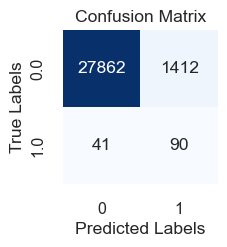

In [152]:

# NORMAL PARAMS & 0.7 THRESHOLD

conf_matrix_xgb = confusion_matrix(y_test,ensemble_predictions)
plt.figure(figsize=(2, 2))
sns.heatmap(conf_matrix_xgb, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=clf_xgb.classes_, yticklabels=clf_cat.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [153]:
print('AUC: {:.2f}%'.format(roc_auc_score(y_test, ensemble_predictions) * 100))
print('F1: {:.2f}%'.format(f1_score(y_test, ensemble_predictions) * 100))
print('Precision: {:.2f}%'.format(precision_score(y_test, ensemble_predictions) * 100))
print('Recall: {:.2f}%'.format(recall_score(y_test, ensemble_predictions) * 100))
print('Accuracy: {:.2f}%'.format(accuracy_score(y_test, ensemble_predictions) * 100))

AUC: 81.94%
F1: 11.02%
Precision: 5.99%
Recall: 68.70%
Accuracy: 95.06%


In [154]:
df_1.head()

,ACC_NO,MIN_DUE_AMT_1,MIN_DUE_AMT_2,MIN_DUE_AMT_3,MIN_DUE_AMT_4,MIN_DUE_AMT_5,MIN_DUE_AMT_6,TOT_SPEND_AMT_1,TOT_SPEND_AMT_2,TOT_SPEND_AMT_3,TOT_SPEND_AMT_4,TOT_SPEND_AMT_5,TOT_SPEND_AMT_6,PAYMENT_AMT_1,PAYMENT_AMT_2,PAYMENT_AMT_3,PAYMENT_AMT_4,PAYMENT_AMT_5,PAYMENT_AMT_6,TOTAL_OS_1,TOTAL_OS_2,TOTAL_OS_3,TOTAL_OS_4,TOTAL_OS_5,TOTAL_OS_6,A_SCORE_VALUE,FINAL_LIMIT,3_MONTH_NPL_STATUS,AGE,MONTH_END_BAL_LCY,REV_SETT_1_REVOLVER,REV_SETT_1_SETTLER,REV_SETT_2_REVOLVER,REV_SETT_2_SETTLER,REV_SETT_3_REVOLVER,REV_SETT_3_SETTLER,REV_SETT_4_REVOLVER,REV_SETT_4_SETTLER,REV_SETT_5_REVOLVER,REV_SETT_5_SETTLER,REV_SETT_6_REVOLVER,REV_SETT_6_SETTLER,RESTRUCTURED_PLAN_N,RESTRUCTURED_PLAN_Y,ST_GENERAL_ACC_BLCK,ST_GENERAL_ACC_CLST,ST_GENERAL_ACC_DACL,ST_GENERAL_ACC_DCBK,ST_GENERAL_ACC_DLNQ,ST_GENERAL_ACC_DRSP,ST_GENERAL_ACC_NORM,ST_GENERAL_ACC_PCLS,ST_GENERAL_ACC_RCDF,ST_GENERAL_ACC_RCLS,ST_GENERAL_ACC_RCPM,ST_GENERAL_ACC_RCSM,ST_GENERAL_ACC_RCSS,ST_GENERAL_ACC_RSET,ST_GENERAL_ACC_SACC,ST_GENERAL_ACC_SETT,ST_GENERAL_ACC_TERM,ST_GENERAL_ACC_WROF,GENDER_F,GENDER_M,PRODUCT_P13635,PRODUCT_P2f44d,PRODUCT_P3c2a4,PRODUCT_P3dbc4,PRODUCT_P59e14,PRODUCT_P78a55,PRODUCT_P7fc9a,PRODUCT_P8f4b3,PRODUCT_Pacee4,PRODUCT_Pd9c22,PRODUCT_Pdbb26,PRODUCT_Pdc921,PRODUCT_Pf4d80,LATE_PAY_FEE,OVER_LIMIT_FEE
0,93944.0,542.70,0.00,0.00,0.00,0.00,0.00,12896.00,78185.72,16409.23,9008.00,0.00,0.00,3000.0,0.0,42000.0,3000.0,1000.0,2000.0,137387.06,125209.110,46277.59,65720.36,59712.36,60712.36,194.0,317000.0,0.0,56.0,397.13,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1750.0,0.0
1,7238.0,7798.39,4076.19,2045.47,1551.43,7527.77,887.62,79873.03,67408.22,165612.27,87593.55,42954.06,179232.44,195000.0,51500.0,52000.0,39000.0,188200.0,22500.0,140000.80,255127.770,232021.77,117428.98,68785.43,213981.38,217.0,1000000.0,0.0,35.0,0.00,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1750.0,0.0
2,11226.0,0.00,0.00,0.00,0.00,0.00,250.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,-76.31,-76.310,-76.31,-76.31,-76.31,-76.31,231.0,1037000.0,0.0,55.0,0.00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,94712.0,818.80,650.04,579.68,830.91,577.58,636.81,0.00,0.00,1739.70,0.00,0.00,6314.00,13000.0,20500.0,16300.0,14500.0,20800.0,14500.0,97219.38,110219.375,130469.38,139029.67,153529.69,174329.67,233.0,500000.0,0.0,37.0,0.00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,119466.0,570.24,618.13,602.91,250.00,250.00,250.00,0.00,42779.00,8278.68,17041.09,2238.00,0.00,15000.0,15500.0,16200.0,5500.0,3500.0,3500.0,97667.70,112667.700,85388.70,93310.02,81768.93,83030.93,201.0,376000.0,0.0,56.0,0.00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1750.0,0.0


In [155]:
print(classification_report(y_test,ensemble_predictions))

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97     29274
         1.0       0.06      0.69      0.11       131

    accuracy                           0.95     29405
   macro avg       0.53      0.82      0.54     29405
weighted avg       0.99      0.95      0.97     29405



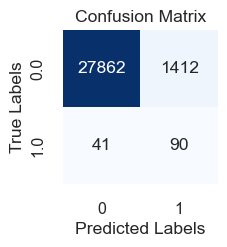

In [156]:

# NORMAL PARAMS & 0.7 THRESHOLD

conf_matrix_xgb = confusion_matrix(y_test,ensemble_predictions_proba_70)
plt.figure(figsize=(2, 2))
sns.heatmap(conf_matrix_xgb, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=clf_xgb.classes_, yticklabels=clf_cat.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [157]:
print('AUC: {:.2f}%'.format(roc_auc_score(y_test, xgb_pred) * 100))
print('F1: {:.2f}%'.format(f1_score(y_test, xgb_pred) * 100))
print('Precision: {:.2f}%'.format(precision_score(y_test, xgb_pred) * 100))
print('Recall: {:.2f}%'.format(recall_score(y_test, xgb_pred) * 100))
print('Accuracy: {:.2f}%'.format(accuracy_score(y_test, xgb_pred) * 100))

AUC: 88.49%
F1: 6.06%
Precision: 3.14%
Recall: 89.31%
Accuracy: 87.67%


In [158]:
print('AUC: {:.2f}%'.format(roc_auc_score(y_test, cat_pred) * 100))
print('F1: {:.2f}%'.format(f1_score(y_test, cat_pred) * 100))
print('Precision: {:.2f}%'.format(precision_score(y_test, cat_pred) * 100))
print('Recall: {:.2f}%'.format(recall_score(y_test, cat_pred) * 100))
print('Accuracy: {:.2f}%'.format(accuracy_score(y_test, cat_pred) * 100))

AUC: 65.62%
F1: 20.29%
Precision: 14.84%
Recall: 32.06%
Accuracy: 98.88%


In [159]:
lgb_pred = clf_lgb.predict(X_test)

In [160]:
print('AUC: {:.2f}%'.format(roc_auc_score(y_test, lgb_pred) * 100))
print('F1: {:.2f}%'.format(f1_score(y_test, lgb_pred) * 100))
print('Precision: {:.2f}%'.format(precision_score(y_test, lgb_pred) * 100))
print('Recall: {:.2f}%'.format(recall_score(y_test, lgb_pred) * 100))
print('Accuracy: {:.2f}%'.format(accuracy_score(y_test, lgb_pred) * 100))

AUC: 57.16%
F1: 18.45%
Precision: 25.33%
Recall: 14.50%
Accuracy: 99.43%


In [161]:
print(classification_report(y_test,lgb_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     29274
         1.0       0.25      0.15      0.18       131

    accuracy                           0.99     29405
   macro avg       0.62      0.57      0.59     29405
weighted avg       0.99      0.99      0.99     29405



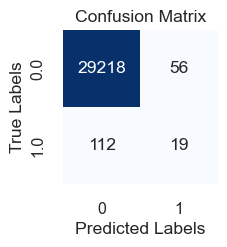

In [162]:

# NORMAL PARAMS & 0.7 THRESHOLD

conf_matrix_xgb = confusion_matrix(y_test,lgb_pred)
plt.figure(figsize=(2, 2))
sns.heatmap(conf_matrix_xgb, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=clf_xgb.classes_, yticklabels=clf_cat.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

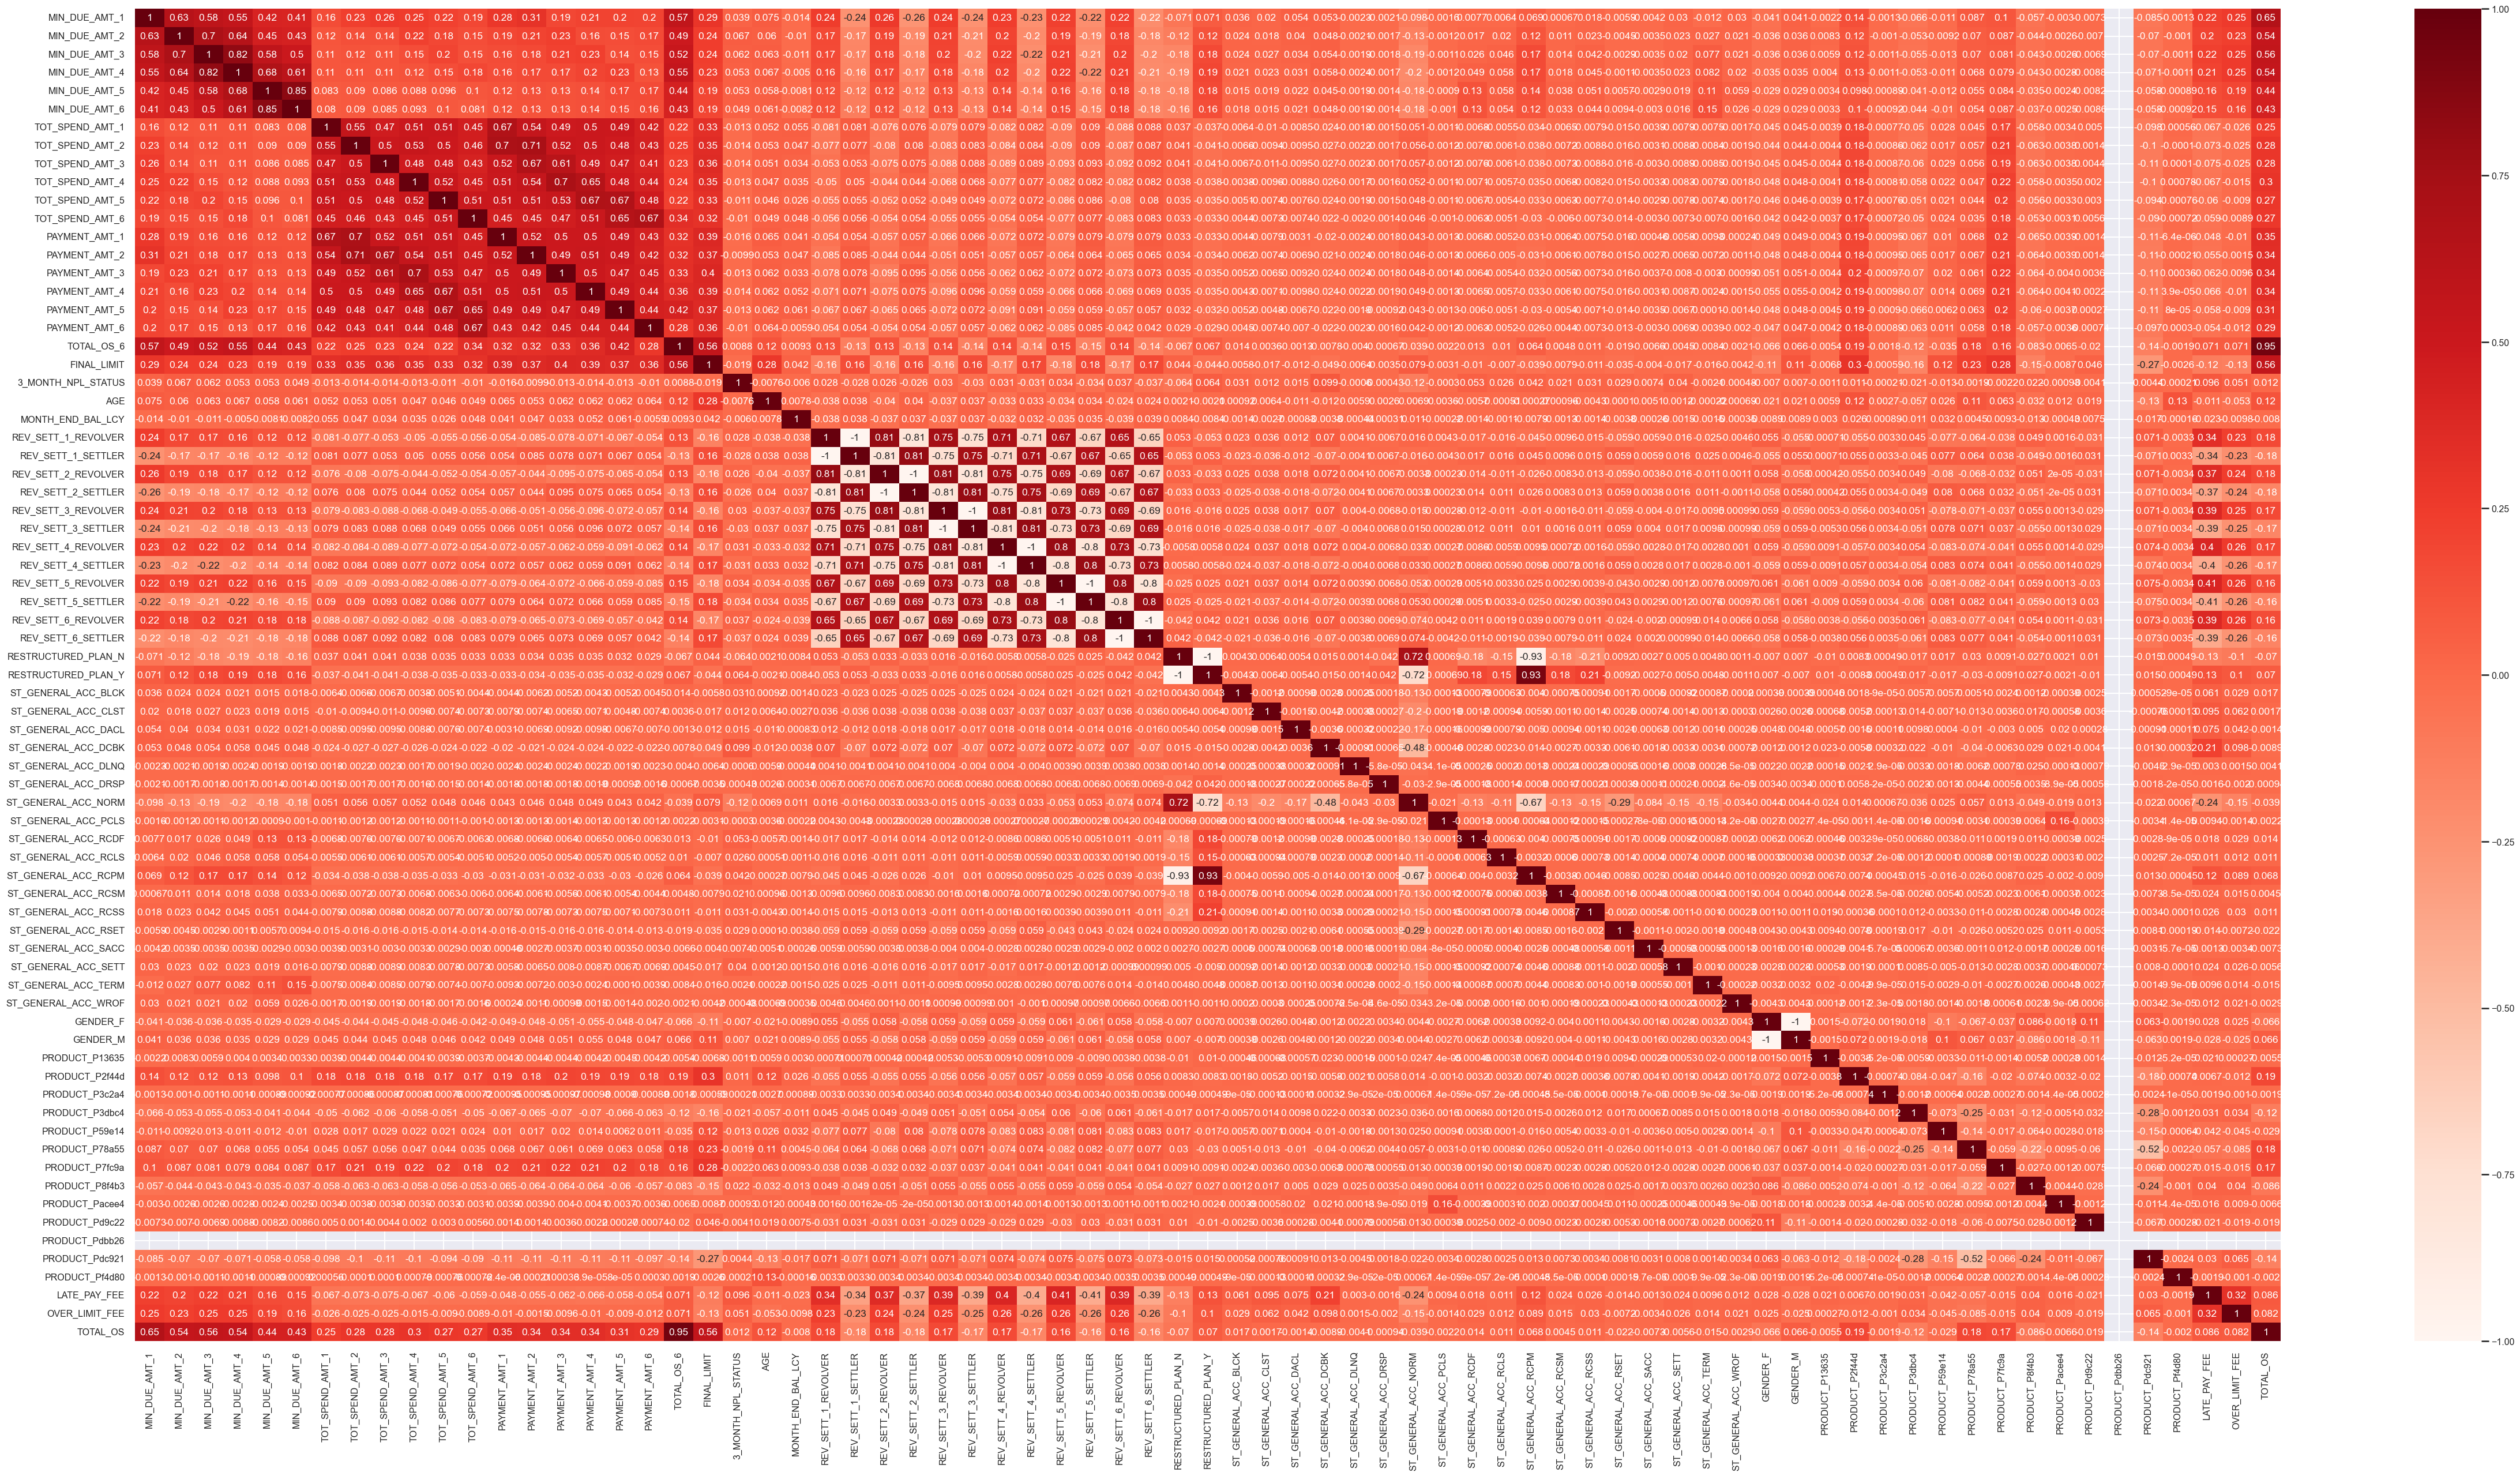

In [114]:
sns.set(rc={'figure.figsize':(60,30)})
sns.set_context("talk", font_scale=0.7)
    
sns.heatmap(df_3.iloc[:,1:].corr(), cmap='Reds', annot=True);